# Manual optimization

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading train, validation and test sets

In [ ]:
ds = tfds.load('malaria', 
               split=('train[:60%]', 'train[60%:80%]', 'train[80%:]'), 
               shuffle_files=False,
              data_dir='/content/gdrive/MyDrive/datasets/Malaria',
               batch_size=32,
              download=True,
              as_supervised=True,
              with_info=False)

# Model optimization

In [ ]:
def build_model(init_filters, kernel_size, num_convols):
    inputs = keras.Input(shape=(None, None, 3))
    x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    num_chan = init_filters
    x = keras.layers.Conv2D(
        filters=init_filters,
        kernel_size=kernel_size,
        strides=(1, 1),
        padding="valid",
        activation='relu')(x)
    for i in range(num_convols):
        # i is the number of convlutions with MaxPooling
        # There is another convolution with GlobalMaxPooling
        if i != 0:
            x = keras.layers.MaxPooling2D(
                pool_size=(2, 2), 
                strides=None, 
                padding="valid")(x)
            num_chan = init_filters * (i + 1)
            x = keras.layers.Conv2D(
                filters=num_chan,
                kernel_size=kernel_size,
                strides=(1, 1),
                padding="valid",
                activation='relu')(x)
    x = keras.layers.GlobalMaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=num_chan,
                            activation="relu",
                          kernel_regularizer=None)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='Adam',
         loss='binary_crossentropy',
         metrics=['accuracy'])    
    return model

In [ ]:
model = build_model(128, 2, 5)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 256)   131328    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 256)  0         
 2D)                                                       

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="max",
        baseline=None,
        restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/datasets/Malaria/checkpoints/model_{epoch}',
        save_freq='epoch')
    ]

In [ ]:
history = model.fit(
    ds[0],
    epochs=50,
    verbose="auto",
    callbacks=callbacks,
    validation_data=ds[1]
)

Epoch 1/50
517/517 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8171

517/517 [==============================] - 126s 242ms/step - loss: 0.3307 - accuracy: 0.8171 - val_loss: 0.1459 - val_accuracy: 0.9543
Epoch 2/50
517/517 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9554

517/517 [==============================] - 113s 219ms/step - loss: 0.1528 - accuracy: 0.9554 - val_loss: 0.1352 - val_accuracy: 0.9584
Epoch 3/50
517/517 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9571

517/517 [==============================] - 113s 219ms/step - loss: 0.1440 - accuracy: 0.9571 - val_loss: 0.1236 - val_accuracy: 0.9595
Epoch 4/50
517/517 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9594

517/517 [==============================] - 113s 219ms/step - loss: 0.1346 - accuracy: 0.9594 - val_loss: 0.1192 - val_accuracy: 0.9595
Epoch 5/50
517/517 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9606

517/517 [==============================] - 113s 219ms/step - loss: 0.1274 - accuracy: 0.9606 - val_loss: 0.1254 - val_accuracy: 0.9586
Epoch 6/50
517/517 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9615

517/517 [==============================] - 113s 219ms/step - loss: 0.1229 - accuracy: 0.9615 - val_loss: 0.1189 - val_accuracy: 0.9555
Epoch 7/50
517/517 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9626

517/517 [==============================] - 113s 218ms/step - loss: 0.1172 - accuracy: 0.9626 - val_loss: 0.1218 - val_accuracy: 0.9572
Epoch 8/50
517/517 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9641Restoring model weights from the end of the best epoch: 3.


517/517 [==============================] - 113s 219ms/step - loss: 0.1093 - accuracy: 0.9641 - val_loss: 0.1197 - val_accuracy: 0.9563
Epoch 8: early stopping


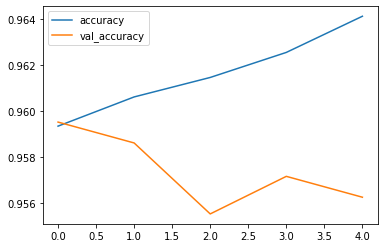

In [ ]:
pd.DataFrame({'accuracy': history.history['accuracy'][3:],
              'val_accuracy': history.history['val_accuracy'][3:]}).plot.line();

In [ ]:
 max(history.history['val_accuracy'])

0.9595354795455933

# The best result was achieved at 64, 2, 4 but variance between epochs is larger then difference between hyperparameter sets. 